In [18]:
using Base.Threads
println("Number of threads: ", nthreads())


# To set threads for paralel chains go to command prompt 
# see how many threads are available on the CPU with:
# "wmic cpu get NumberOfLogicalProcessors"
# Set the number of threads you want to use with:
# "set JULIA_NUM_THREADS=6 (6 as an example)"
# Then open julia with threads in vs code with:
# "code ."


Number of threads: 1


In [19]:
using Revise  # auto reload

includet("State_Space_Model.jl")
using .state_space_model

includet("Kalman.jl")
using .kalman

includet("MCMC.jl")
using .MCMC

includet("Particle.jl")
using .ParticleFilter




using Random
using LinearAlgebra
using Statistics
using Distributions
using ProgressMeter
using SpecialFunctions
using Plots
using StatsPlots
using CSV
using DataFrames
using BenchmarkTools 

using MCMCChains  # For diagnostics
using ArviZ


## Model & Priors

In [20]:
# Parameters in θ
θ_elements = ["ρ", "λ_c", "σ²_ε, y", "σ²_ξ, y", "σ²_κ, y"]
n_params = length(θ_elements)
# cycle_order
cycle_order = 1



# Create the support matrix
support = [
    0.0 0.97  # ρ
    0.0 π;  # λ_c
    0.0 Inf;  # σ²_ε, y
    0.0 Inf;  # σ²_ξ, y
    0.0 Inf  # σ²_κ, y 
]

# Create the prior distributions 
prior_distributions = (
    "uniform",  # ρ
    "uniform",  # λ_c
    "inverse_gamma",  # σ²_ε, y
    "inverse_gamma",  # σ²_ξ, y 
    "inverse_gamma",  # σ²_κ, y
)

# Create the prior hyperparameters matrix
prior_hyperparameters_1 = [
    0.0 0.96;  # ρ
    0.0 3.0;  # λ_c
    1e-6 1e-6;  # σ²_ε, y
    1e-6 1e-6;  # σ²_ξ, y
    1e-6 1e-6  # σ²_κ, y
]

prior_info1 = (
    support = support,
    distributions = prior_distributions,
    parameters = prior_hyperparameters_1,
)

# Create the prior hyperparameters matrix
prior_hyperparameters_2 = [
    0.0 0.96;  # ρ
    0.0 3.0;  # λ_c
    1.0 3.0;  # σ²_ε, y
    1.0 3.0;  # σ²_ξ, y
    1.0 3.0  # σ²_κ, y
]


prior_info2 = (
    support = support,
    distributions = prior_distributions,
    parameters = prior_hyperparameters_2,
)

# collect prior info. Need a prior_info element for each chain
prior_info_collection = [prior_info1]#, prior_info1, prior_info1, prior_info1, prior_info1, prior_info1]
n_chains = length(prior_info_collection)

#States in α
α_elements = [
    "u_t^y", 
    "β_t^y", 
    # "ψ_{2,t}^y", 
    # "ψ_{2,t}^{y*}", 
    "ψ_{1,t}^y", 
    "ψ_{1,t}^{y*}", 
]



4-element Vector{String}:
 "u_t^y"
 "β_t^y"
 "ψ_{1,t}^y"
 "ψ_{1,t}^{y*}"

## Data

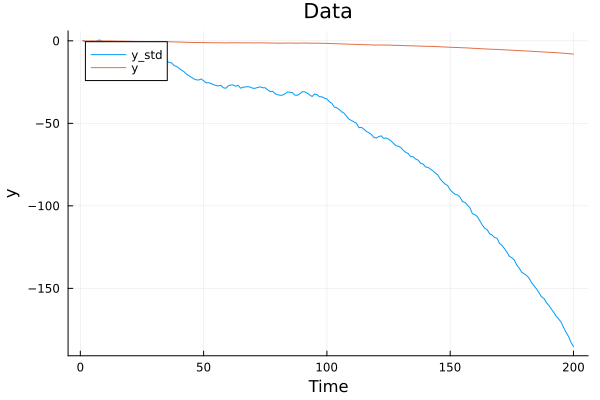

4×4 Matrix{Float64}:
 1.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0
 0.0  0.0  1.0  0.0
 0.0  0.0  0.0  1.0

In [21]:
simulate = true
standardize = true

if simulate
    # True parameters
    ρ = 0.5
    λ_c = 0.1
    σ²_ε_y = 4*10e-5
    σ²_ξ_y = 4*10e-6
    σ²_κ_y = 6*10e-5
    # ρ = 0.6
    # λ_c = 0.1
    # σ²_ε_y = 7000
    # σ²_ξ_y = 100
    # σ²_κ_y = 8000
    # ρ = 0.5
    # λ_c = 0.1
    # σ²_ε_y = 0.3
    # σ²_ξ_y = 0.05
    # σ²_κ_y = 0.3

    θ_true = [ρ, λ_c, σ²_ε_y, σ²_ξ_y, σ²_κ_y]
    n_obs = 200
    y, α = simulate_data(θ_true, cycle_order, n_obs)
    y_std, σʸ = standardize_data(y)
    if standardize == false
        y_std = y
        σʸ = 1.0
    end
    θ_true = [ρ, λ_c, σ²_ε_y/(σʸ[1]^2), σ²_ξ_y/(σʸ[1]^2), σ²_κ_y/(σʸ[1]^2)]
    
   


else
    # Load data 
    data = CSV.read("data.csv", DataFrame)
    # Extract y 
    y = data.y
    # make y a matrix
    y = Matrix(y')
    # log transform y
    # y = log.(y)
    println(size(y))
    y_std, σʸ = standardize_data(y)
    if standardize == false
        y_std = y
        σʸ = 1.0
    end
    n_obs = length(y)
end


# plot data
plot(y_std[1,:], label="y_std", title="Standardized data", xlabel="Time", ylabel="y", legend=:topleft)
plot!(y[1,:], label="y", title="Data", xlabel="Time", ylabel="y", legend=:topleft)
display(plot!())

# Initial states
α0 = zeros(length(α_elements))
α0[1] = y[1]
P0 = 1*Matrix{Float64}(I, length(α_elements), length(α_elements))

  30.203 ms (2411415 allocations: 109.01 MiB)
  1.009 ms (18665 allocations: 1.32 MiB)
Log likelihood particle filter: -248.86272830237277
Log likelihood kalman filter: -90.2363122435599
(4, 200)
(4, 200)


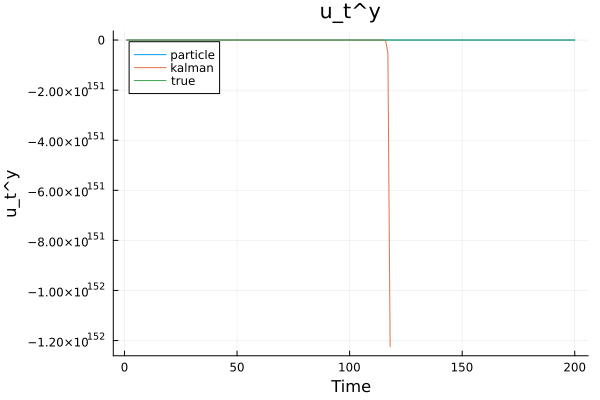

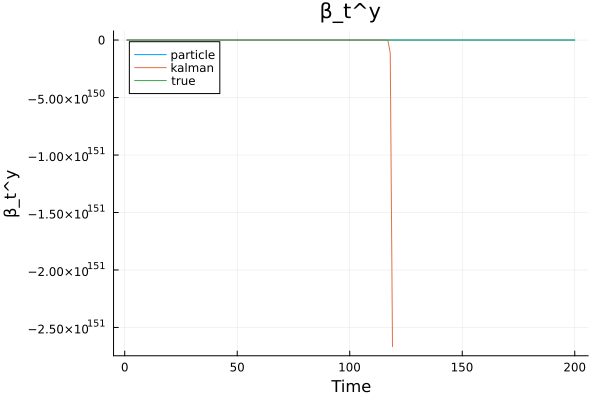

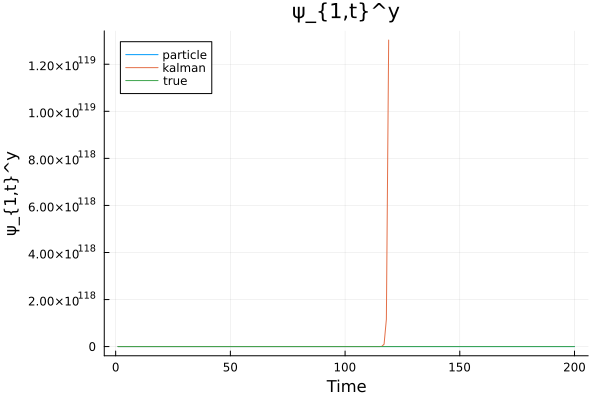

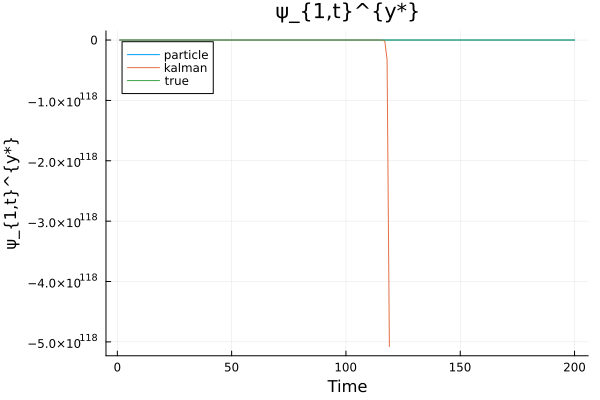

In [ ]:
if simulate

    n_particles_values = [500, 1000, 2000]
    num_runs = 20  

    mean_times = zeros(length(n_particles_values))
    mean_logL = zeros(length(n_particles_values))
    std_logL = zeros(length(n_particles_values))

    # Loop over each particle count
    for (idx, n_particles) in enumerate(n_particles_values)
        logL_runs = zeros(num_runs)
        time_runs = zeros(num_runs)
        for run in 1:num_runs
            # Measure the execution time with @elapsed
            t = @elapsed begin
                log_L_particle, _ = particle_filter(y_std, θ_true, α0, P0, cycle_order, σʸ, N_particles=n_particles)
            end
            time_runs[run] = t
            logL_runs[run] = log_L_particle
        end
        mean_times[idx] = mean(time_runs)
        mean_logL[idx] = mean(logL_runs)
        std_logL[idx] = std(logL_runs)
        println("Particles: ", n_particles, 
                " | Mean log likelihood: ", mean_logL[idx],
                " | Std log likelihood: ", std_logL[idx],
                " | Mean time: ", mean_times[idx])
    end

    # Plot execution time vs. number of particles
    p_time = plot(n_particles_values, mean_times,
                  marker=:o,
                  xlabel="Number of Particles",
                  ylabel="Mean Execution Time (s)",
                  title="Execution Time vs. Number of Particles",
                  legend=false)

    # Plot standard deviation of log likelihood vs. number of particles
    p_logL = plot(n_particles_values, std_logL,
                  marker=:o,
                  xlabel="Number of Particles",
                  ylabel="Std of Log Likelihood",
                  title="Log Likelihood Variability vs. Number of Particles",
                  legend=false)

    display(p_time)
    display(p_logL)

    #Run and print the Kalman filter results
    Log_L_kalman, states_kalman, _ = diffuse_kalman_filter(y_std, θ_true, α0, P0, cycle_order, σʸ, true, false)
    println("Log likelihood kalman filter: ", Log_L_kalman)

    # Plot the state trajectories from the particle and Kalman filters
    log_L_particle, states_particle = particle_filter(y_std, θ_true, α0, P0, cycle_order, σʸ, N_particles=1000)
    for i in 1:length(α_elements)
        p = plot(states_particle[i, :].*σʸ, label="particle", title=α_elements[i],
                 xlabel="Time", ylabel=α_elements[i], legend=:topleft)
        plot!(p, states_kalman[i, :].*σʸ, label="kalman")
        plot!(p, α[i, :], label="true")
        display(p)
    end
end


## MCMC

In [23]:
θ_chain_all, θ_chain_init_all, α_draws_all = MCMC_estimation_parallel(y_std, prior_info_collection, α0, P0, cycle_order, σʸ;
                                   filter_type="kalman",
                                   iter_init=10000,
                                   burn_init=5000,
                                   iter_rec=10000,
                                   burn_rec=5000,
                                   ω=1.0,
                                   target_low=0.25,
                                   target_high=0.35,
                                   n_chains=n_chains)


Chain 1 on thread 1 completed in 24.049000024795532 seconds.


([0.01194981597910987 2.627645559804402 … 218.77936183866706 2.7489865720019506e-6; 0.01194981597910987 2.627645559804402 … 218.77936183866706 2.7489865720019506e-6; … ; 0.011950709410862135 2.6273855920222364 … 218.23568765075856 2.73172385159497e-6; 0.011950709410862135 2.6273855920222364 … 218.23568765075856 2.73172385159497e-6;;;], [0.0019553572026805247 2.044318349256443 … 1.6064897590778102 4.254056610114848; 0.0019553572026805247 2.044318349256443 … 1.6064897590778102 4.254056610114848; … ; 0.011839317581368842 2.6289492583959095 … 214.64014674783172 2.7581680022392126e-6; 0.011839317581368842 2.6289492583959095 … 214.64014674783172 2.7581680022392126e-6;;;], [-0.5255748813948189 0.518832091603246 0.8249382090684416 -1.1000030372954306; -1.1133588540788666 1.10494105261157 1.414617409477278 0.2355095887892298; … ; 0.10187342089155774 -0.13307121618910717 0.20299374444353546 1.8916104072224005; 0.4119017338892315 -0.4352441814312838 -0.11744671948899804 -0.012878402207801197;;; -

In [24]:

# θ_chain_all, θ_chain_init_all, α_draws_all = MCMC_estimation(y_std, prior_info_collection, α0, P0, cycle_order, σʸ;
# filter_type = "kalman",
# iter_init = 1000, 
# burn_init = 500,
#  iter_rec = 1000,
# burn_rec = 500,
# N_particles = 100,
# ω = 1.0,
# n_chains = n_chains)

# println(size(θ_chain_all))
# println(size(α_draws_all))



Chains MCMC chain (10000×5×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
parameters        = ρ, λ_c, σ²_ε, y, σ²_ξ, y, σ²_κ, y

Summary Statistics
  parameters       mean        std      mcse   ess_bulk   ess_tail      rhat   ⋯
      Symbol    Float64    Float64   Float64    Float64    Float64   Float64   ⋯

           ρ     0.0169     0.0127    0.0025    27.1301    73.6917    1.4314   ⋯
         λ_c     2.4288     0.5117    0.0937    26.6905    48.1872    1.7396   ⋯
     σ²_ε, y     0.0161     0.0819    0.0088    27.1927    66.1659    1.6009   ⋯
     σ²_ξ, y   219.4472   121.4905   18.0059    39.3848    59.1463    1.5301   ⋯
     σ²_κ, y     0.0316     0.2671    0.0277    23.1382    26.1106    1.8266   ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%      25.0%      50.0%      75.0%      97.5% 
      Symbol   Float64    Float64    Float64    Float64    Float64 

 

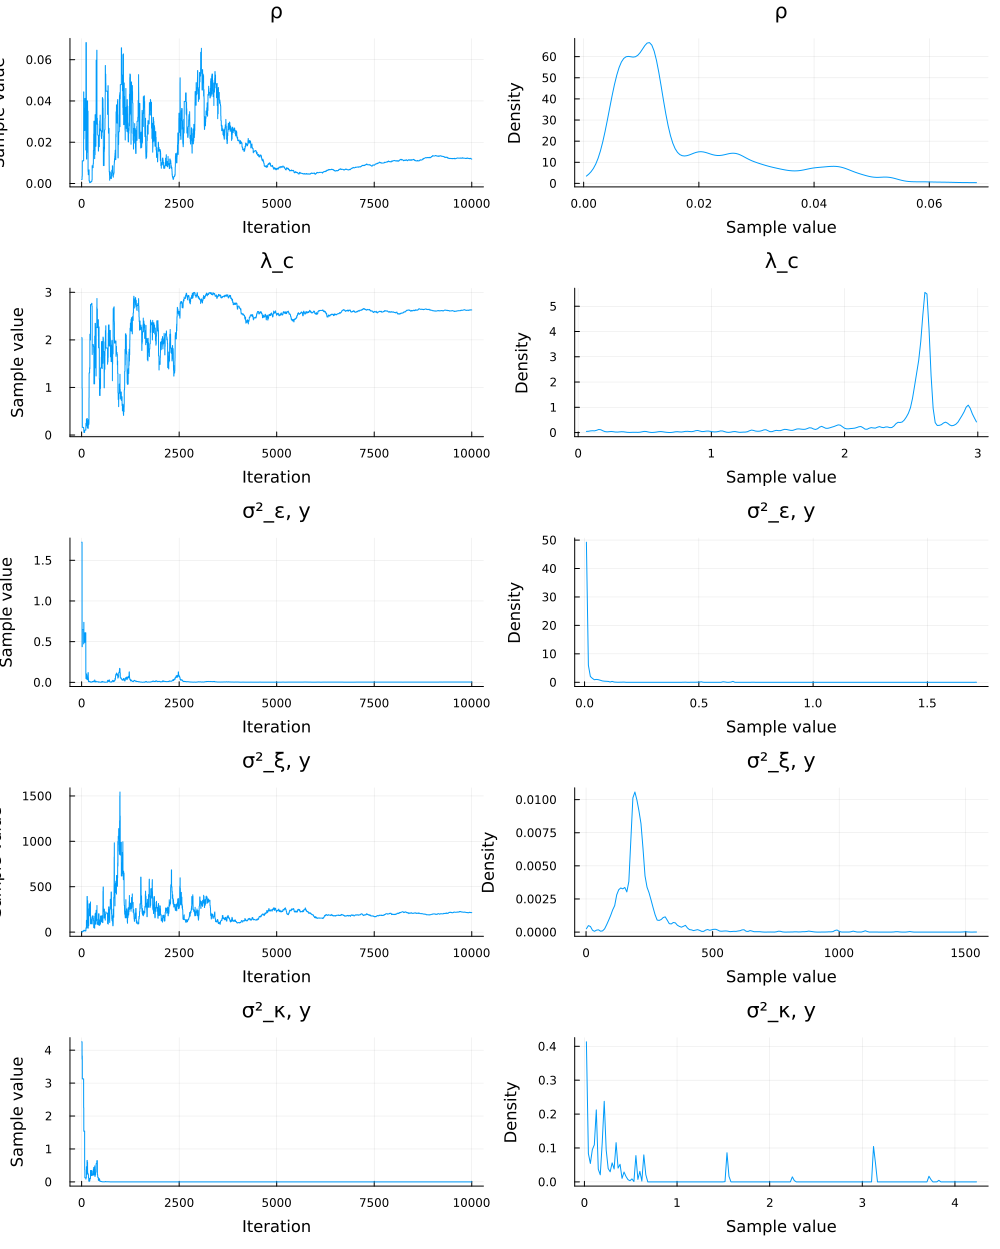

In [25]:
chain_init = Chains(θ_chain_init_all, θ_elements)
display(chain_init)
plot(chain_init)

Chains MCMC chain (5000×5×1 Array{Float64, 3}):

Iterations        = 1:1:5000
Number of chains  = 1
Samples per chain = 5000
parameters        = ρ, λ_c, σ²_ε, y, σ²_ξ, y, σ²_κ, y

Summary Statistics
  parameters       mean       std      mcse   ess_bulk   ess_tail      rhat    ⋯
      Symbol    Float64   Float64   Float64    Float64    Float64   Float64    ⋯

           ρ     0.0119    0.0000    0.0000    14.1246    55.2518    1.1926    ⋯
         λ_c     2.6275    0.0002    0.0000    13.5166    32.7014    1.3655    ⋯
     σ²_ε, y     0.0037    0.0000    0.0000    11.9590    20.2703    1.6723    ⋯
     σ²_ξ, y   218.4208    0.2028    0.0629    10.9560    23.3569    2.1208    ⋯
     σ²_κ, y     0.0000    0.0000    0.0000    10.8452    21.9528    2.0772    ⋯
                                                                1 column omitted

Quantiles
  parameters       2.5%      25.0%      50.0%      75.0%      97.5% 
      Symbol    Float64    Float64    Float64    Float64    Float64 

  

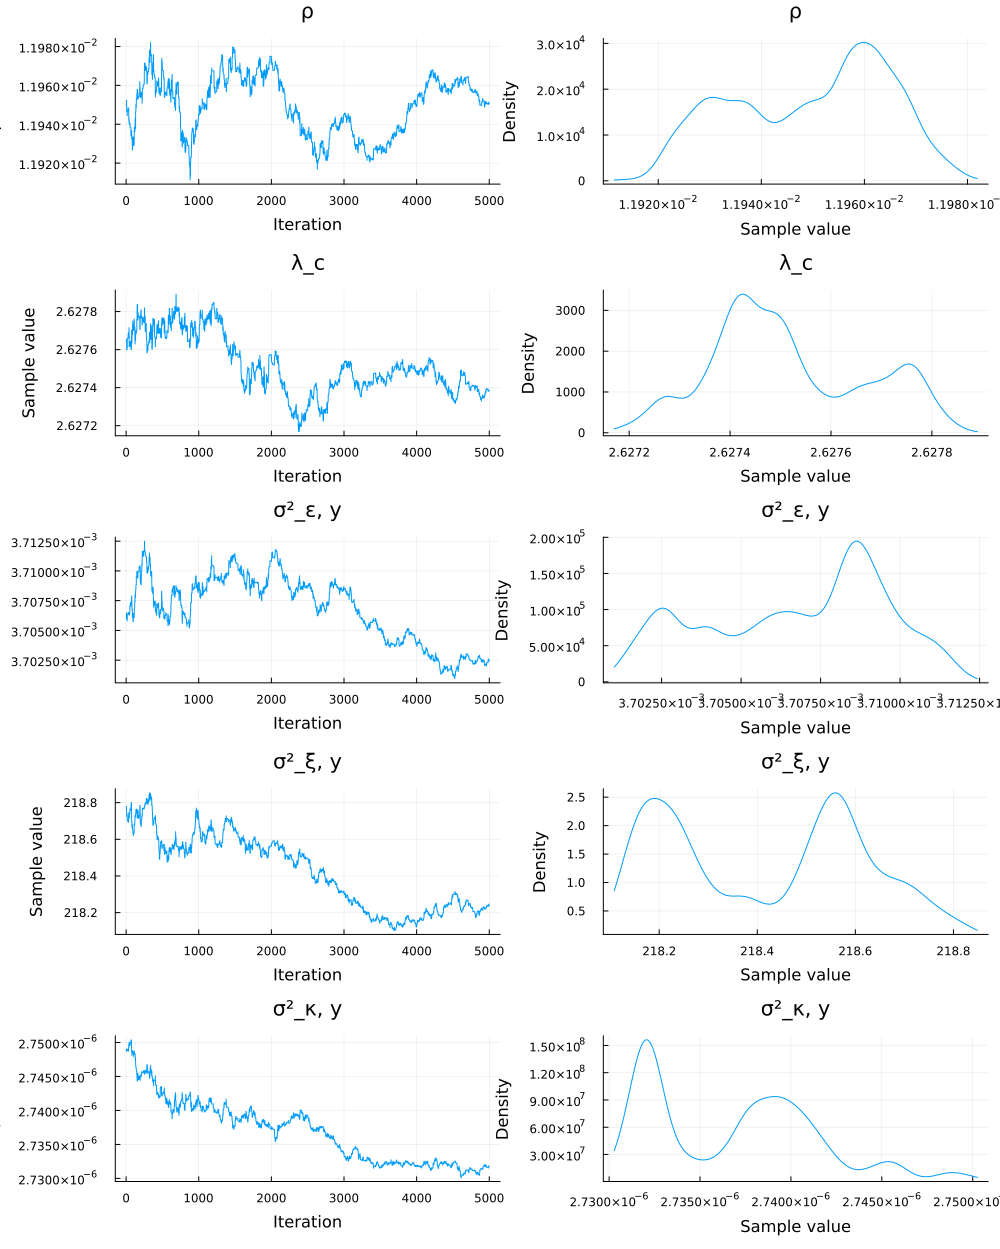

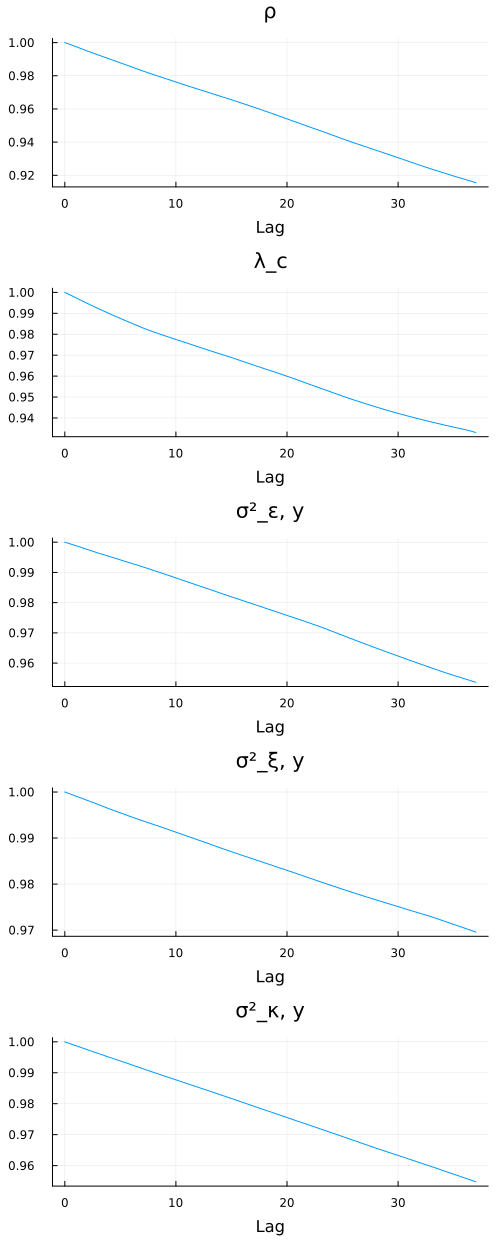

In [26]:

chain_rec = Chains(θ_chain_all, θ_elements)
display(chain_rec)

display(plot(chain_rec))
# display(corner(chain_rec))
display(autocorplot(chain_rec))

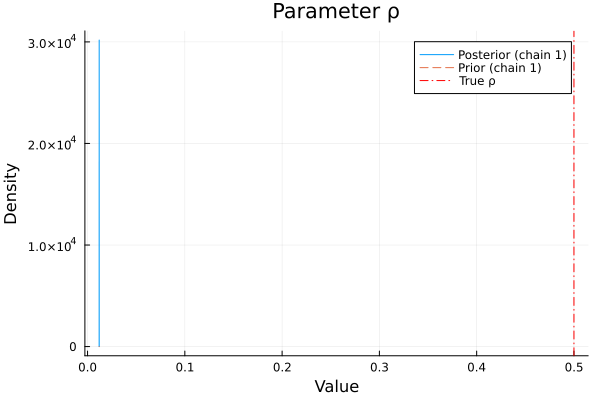

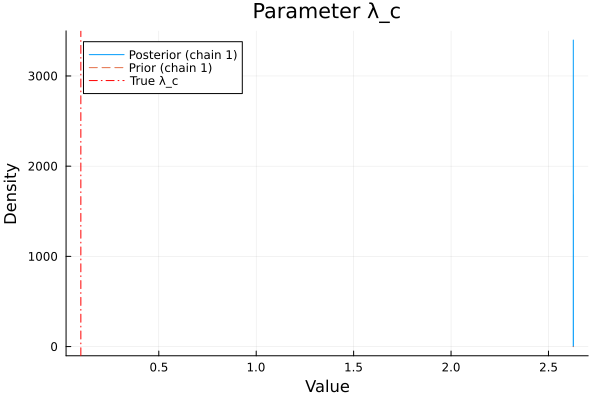

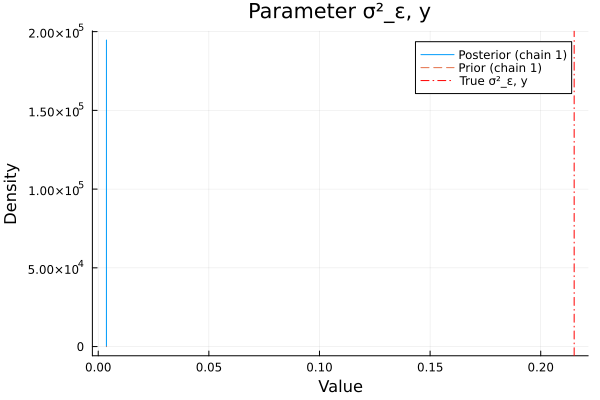

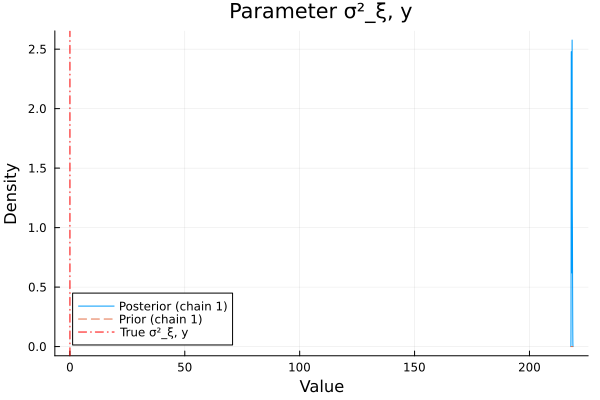

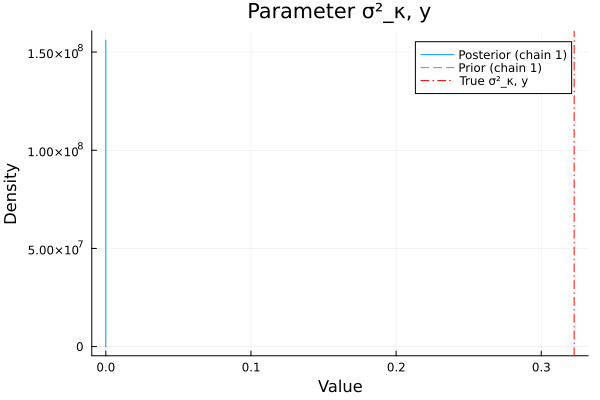

In [27]:

for i in 1:size(θ_chain_all, 2)
    p = plot(title = "Parameter $(θ_elements[i])", xlabel = "Value", ylabel = "Density")
    
    # For each chain, plot the chain-specific posterior density
    for j in 1:n_chains
        samples = θ_chain_all[:, i, j]
        density!(p, samples, label = "Posterior (chain $j)")
    end
    
    # for each chain, overlay the prior density (using a dashed line)
    for j in 1:n_chains
        dist_type = prior_info_collection[j].distributions[i]
        hp1 = prior_info_collection[j].parameters[i, 1]
        hp2 = prior_info_collection[j].parameters[i, 2]
        if dist_type == "uniform"
            prior = Uniform(hp1, hp2)
        elseif dist_type == "beta"
            prior = Beta(hp1, hp2)
        elseif dist_type == "normal"
            prior = Normal(hp1, hp2)
        elseif dist_type == "inverse_gamma"
            prior = InverseGamma(hp1, hp2)
        else
            error("Unknown prior distribution: $dist_type")
        end
        samples = θ_chain_all[:, i, j]
        x_min = minimum(samples)
        x_max = maximum(samples)
        xs = range(x_min, x_max, length = 200)
        # Plot the prior density using a dashed line style
        plot!(p, xs, pdf.(prior, xs), label = "Prior (chain $j)", linestyle = :dash)
    end

    # If simulation is used, add the true value
    if simulate
        vline!(p, [θ_true[i]], label = "True $(θ_elements[i])", linestyle = :dashdot, color = :red)
    end

    display(p)
end


In [28]:
# α_draws_all has shape (iter_rec, state_dim, obs, n_chains)
n_chains = size(α_draws_all, 4)
n_states = size(α_draws_all, 2)


plots_vec = []
for i in 1:n_states
    for ch in 1:n_chains
        # Extract draws for the current chain 
        α_draws = α_draws_all[:,:,:,ch].*σʸ
    
        # Compute the mean over iterations (dimension 1) 
        α_mean = dropdims(mean(α_draws, dims=1), dims=1)
    
        # Compute the 2.5% and 97.5% quantiles over iterations.
        α_ci = mapslices(x -> quantile(x, [0.025, 0.975]), α_draws, dims=1)
    
        p = plot(α_mean[i, :],
                 ribbon = (α_ci[2, i, :] .- α_mean[i, :]),
                 label = "Estimated $(α_elements[i])")
        if simulate
            plot!(p, α[i, :], label = "True")
        end
        push!(plots_vec, p)
    end
end

combined_plot = plot(plots_vec..., layout = (n_states, n_chains), size=(1000, 300*n_states))
display(combined_plot)


ArgumentError: ArgumentError: quantiles are undefined in presence of NaNs or missing values

## MLE

In [29]:
# using Optim


# lower_bounds = [0.0, 0.0, 1e-12, 1e-12, 1e-12]
# upper_bounds = [1.0, 3.0, 1e6, 1e6, 1e6]
# θ_init = [0.5, 1.5, 0.5, 0.5, 0.5]

# objective(θ) = neg_log_likelihood(θ, y, α0, P0, cycle_order, σʸ)
# res = optimize(objective, lower_bounds, upper_bounds, θ_init, Fminbox(BFGS()))
# θ_est = Optim.minimizer(res)

# # Print the results:
# println("MLE Results (with bounded optimization):")
# for (i, param_name) in enumerate(θ_elements)
#     println("Estimated $(param_name): $(θ_est[i])   (True value: $(θ_true[i]))")
# end
# println("Final negative log-likelihood: ", Optim.minimum(res))


In [30]:
# # estimate states
# LogL_diff, α_diff, P_diff = diffuse_kalman_filter(y, θ_est, α0, P0, cycle_order, σʸ,  true, false)

# #plot estimated states and true states
# for i in 1:size(α,2)
#     plot(α[:,i], label="true $(α_elements[i])")
#     plot!(α_diff[:,i], label="estimated $(α_elements[i])")
#     display(plot!())
# end

